# Hodgkin-Huxley Neuron Simulation
## Overview
This notebook implements the Hodgkin-Huxley model, a mathematical representation of action potential initiation and propagation in neurons. The model captures ionic currents through the cell membrane, enabling the simulation of neuronal excitability.

## Objectives
- Simulate neuronal behavior under various external stimuli.
- Visualize dynamics of membrane potential, gating variables, and ionic currents.
- Understand how changes in stimuli affect firing patterns.
- Explore neuronal response to parameter variations.

In [16]:
pip install numpy matplotlib

Note: you may need to restart the kernel to use updated packages.


In [17]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display

## Model Parameters
Below, we define constants and parameters such as membrane capacitance, conductance, and reversal potentials for sodium (Na⁺), potassium (K⁺), and leak channels.

In [18]:
def initialize_parameters():
    '''
    A function to initialize the parameters of our model
    '''
    # Membrane capacitance (µF/cm²)
    C_m = 1.0

    # Maximum conductances (mS/cm²)
    g_Na = 120.0  # Sodium conductance
    g_K = 36.0    # Potassium conductance
    g_L = 0.3     # Leak conductance

    # Reversal potentials (mV)
    E_Na = 50.0   # Sodium reversal potential
    E_K = -77.0   # Potassium reversal potential
    E_L = -54.387 # Leak reversal potential

    return C_m, g_Na, g_K, g_L, E_Na, E_K, E_L

### Model Parameters
The Hodgkin-Huxley model relies on several key parameters that define the electrical and ionic properties of the neuron. Here are the parameters used in this model:

- **Membrane capacitance ($C_m$):** Represents the membrane's ability to store charge, measured in µF/cm².
- **Maximum conductances ($g_{Na}$, $g_K$, $g_L$):** Maximum ion flow rates through sodium (Na⁺), potassium (K⁺), and leak channels, measured in $mS/cm²$.
- **Reversal potentials ($E_{Na}$, $E_K$, $E_L$):** Voltages at which the net ionic current for Na⁺, K⁺, and leak channels is zero, measured in mV.

In [19]:
# These functions compute the rate constants for the gating variables m, h, and n
def alpha_m(V):
    return 0.1 * (V + 40.0) / (1.0 - np.exp(-(V + 40.0) / 10.0))

def beta_m(V):
    return 4.0 * np.exp(-(V + 65.0) / 18.0)

def alpha_h(V):
    return 0.07 * np.exp(-(V + 65.0) / 20.0)

def beta_h(V):
    return 1.0 / (1.0 + np.exp(-(V + 35.0) / 10.0))

def alpha_n(V):
    return 0.01 * (V + 55.0) / (1.0 - np.exp(-(V + 55.0) / 10.0))

def beta_n(V):
    return 0.125 * np.exp(-(V + 65.0) / 80.0)


### Gating Variables and Rate Constants
The gating variables $m$, $h$, and $n$ represent the activation and inactivation states of ion channels:
- $m$: Sodium channel activation.
- $h$: Sodium channel inactivation.
- $n$: Potassium channel activation.

The rate constants ($\alpha$ and $\beta$) determine how these gating variables change with the membrane potential ($V$):
$$
\frac{dm}{dt} = \alpha_m (1 - m) - \beta_m m
$$
$$
\frac{dh}{dt} = \alpha_h (1 - h) - \beta_h h
$$
$$
\frac{dn}{dt} = \alpha_n (1 - n) - \beta_n n
$$
Here, $\alpha$ and $\beta$ are voltage-dependent functions that control the opening and closing of ion channels.


In [20]:
# Creating a function to set up the simulation parameters
def initialize_simulation(t_start=0.0, t_end=50.0, dt=0.01):
    # Time vector
    t = np.arange(t_start, t_end + dt, dt)
    num_steps = len(t)
    return t, num_steps

In [21]:
# Defining a function to initialize the membrane potential and gating variables
def initialize_state_variables(num_steps):
    # Membrane potential (mV)
    V = np.zeros(num_steps)
    V[0] = -65.0  # Typical resting potential for neurons
    
    # Gating variables
    m = np.zeros(num_steps)
    h = np.zeros(num_steps)
    n = np.zeros(num_steps)
    
    # Initial gating variables at steady-state values
    m[0] = alpha_m(V[0]) / (alpha_m(V[0]) + beta_m(V[0]))
    h[0] = alpha_h(V[0]) / (alpha_h(V[0]) + beta_h(V[0]))
    n[0] = alpha_n(V[0]) / (alpha_n(V[0]) + beta_n(V[0]))
    
    return V, m, h, n

### Simulation Initialization
To simulate neuronal behavior, we define:

1. **Time Vector:** Divides the simulation duration into small time steps $dt = 0.01 ms$
2. **State Variables:**
   - **Membrane Potential ($V$):** Starts at the resting potential of $-65 mV$.
   - **Gating Variables ($m, h, n$):** Initialized based on steady-state values.

This setup ensures accurate integration of the differential equations over time.

In [22]:
# Defining External Current
def define_external_current(t, amplitude=10.0, start_time=10.0, end_time=40.0):
    I_ext = np.zeros_like(t)
    I_ext[(t >= start_time) & (t <= end_time)] = amplitude
    return I_ext

### External Current Input
The external current $I_{ext}$ is applied to the neuron to stimulate action potentials. It is defined as:

- **Amplitude:** Strength of the stimulus (e.g., $10 µA/cm²$).
- **Start and End Time:** Specifies the duration of the stimulus (e.g., 10 ms to 40 ms).

This controlled input allows us to observe how the neuron responds to varying stimulus intensities and durations.

In [23]:
# Implementing the Hodgkin-Huxley Model
def hodgkin_huxley_simulation(V, m, h, n, t, I_ext, C_m, g_Na, g_K, g_L, E_Na, E_K, E_L):
    dt = t[1] - t[0]
    num_steps = len(t)
    
    for i in range(1, num_steps):
        V_prev = V[i-1]
        m_prev = m[i-1]
        h_prev = h[i-1]
        n_prev = n[i-1]
        
        # Compute alpha and beta values
        a_m = alpha_m(V_prev)
        b_m = beta_m(V_prev)
        a_h = alpha_h(V_prev)
        b_h = beta_h(V_prev)
        a_n = alpha_n(V_prev)
        b_n = beta_n(V_prev)
        
        # Update gating variables using Euler's method
        m[i] = m_prev + dt * (a_m * (1 - m_prev) - b_m * m_prev)
        h[i] = h_prev + dt * (a_h * (1 - h_prev) - b_h * h_prev)
        n[i] = n_prev + dt * (a_n * (1 - n_prev) - b_n * n_prev)
        
        # Compute ionic currents
        I_Na = g_Na * m[i]**3 * h[i] * (V_prev - E_Na)
        I_K = g_K * n[i]**4 * (V_prev - E_K)
        I_L = g_L * (V_prev - E_L)
        
        # Update membrane potential
        V[i] = V_prev + dt * (I_ext[i] - I_Na - I_K - I_L) / C_m
    
    return V, m, h, n


### Differential Equations in the Hodgkin-Huxley Model
The Hodgkin-Huxley model describes how the membrane potential ($V$) changes over time due to ionic currents:
$$
C_m \frac{dV}{dt} = I_{\text{ext}} - (I_{\text{Na}} + I_{\text{K}} + I_{\text{L}})
$$

Where:

$I_{\text{Na}} = g_{\text{Na}} m^3 h (V - E_{\text{Na}})$: Sodium current

$I_{\text{K}} = g_{\text{K}} n^4 (V - E_{\text{K}})$: Potassium current

$I_{\text{L}} = g_{\text{L}} (V - E_{\text{L}})$: Leak current

The gating variables ($m, h, n$) evolve according to their respective differential equations, as described earlier.

In [24]:
# Function to plot the results
def plot_results(t, V, m, h, n, I_ext):
    plt.figure(figsize=(12, 10))
    
    # Membrane potential over time
    plt.subplot(4, 1, 1)
    plt.plot(t, V, 'b')
    plt.title('Hodgkin-Huxley Neuron Simulation')
    plt.ylabel('Membrane Potential (mV)')
    plt.grid(True)
    
    # Gating variables over time
    plt.subplot(4, 1, 2)
    plt.plot(t, m, 'r', label='m (Na⁺ activation)')
    plt.plot(t, h, 'g', label='h (Na⁺ inactivation)')
    plt.plot(t, n, 'b', label='n (K⁺ activation)')
    plt.ylabel('Gating Variables')
    plt.legend()
    plt.grid(True)
    
    # Ionic currents over time
    plt.subplot(4, 1, 3)
    I_Na = g_Na * m**3 * h * (V - E_Na)
    I_K = g_K * n**4 * (V - E_K)
    I_L = g_L * (V - E_L)
    plt.plot(t, I_Na, 'c', label='I_Na')
    plt.plot(t, I_K, 'm', label='I_K')
    plt.plot(t, I_L, 'y', label='I_L')
    plt.ylabel('Ionic Currents (µA/cm²)')
    plt.legend()
    plt.grid(True)
    
    # External current over time
    plt.subplot(4, 1, 4)
    plt.plot(t, I_ext, 'k')
    plt.xlabel('Time (ms)')
    plt.ylabel('External Current (µA/cm²)')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()


In [25]:
# Initialize parameters
C_m, g_Na, g_K, g_L, E_Na, E_K, E_L = initialize_parameters()

# Initialize simulation
t, num_steps = initialize_simulation()

# Initialize state variables
V, m, h, n = initialize_state_variables(num_steps)

# Define external current
I_ext = define_external_current(t)

# Run the simulation
V, m, h, n = hodgkin_huxley_simulation(
    V, m, h, n, t, I_ext, C_m, g_Na, g_K, g_L, E_Na, E_K, E_L
)


### Visualizing Results
The following plots provide insights into the simulation:

1. **Membrane Potential:** Tracks voltage changes over time.
2. **Gating Variables:** Shows the dynamics of $m$, $h$, and $n$ during the simulation.
3. **Ionic Currents:** Visualizes $I_{\text{Na}}$, $I_{\text{K}}$, and $I_{\text{L}}$.
4. **External Current:** Displays the applied stimulus.


These visualizations help analyze how the neuron generates action potentials and responds to external stimuli.

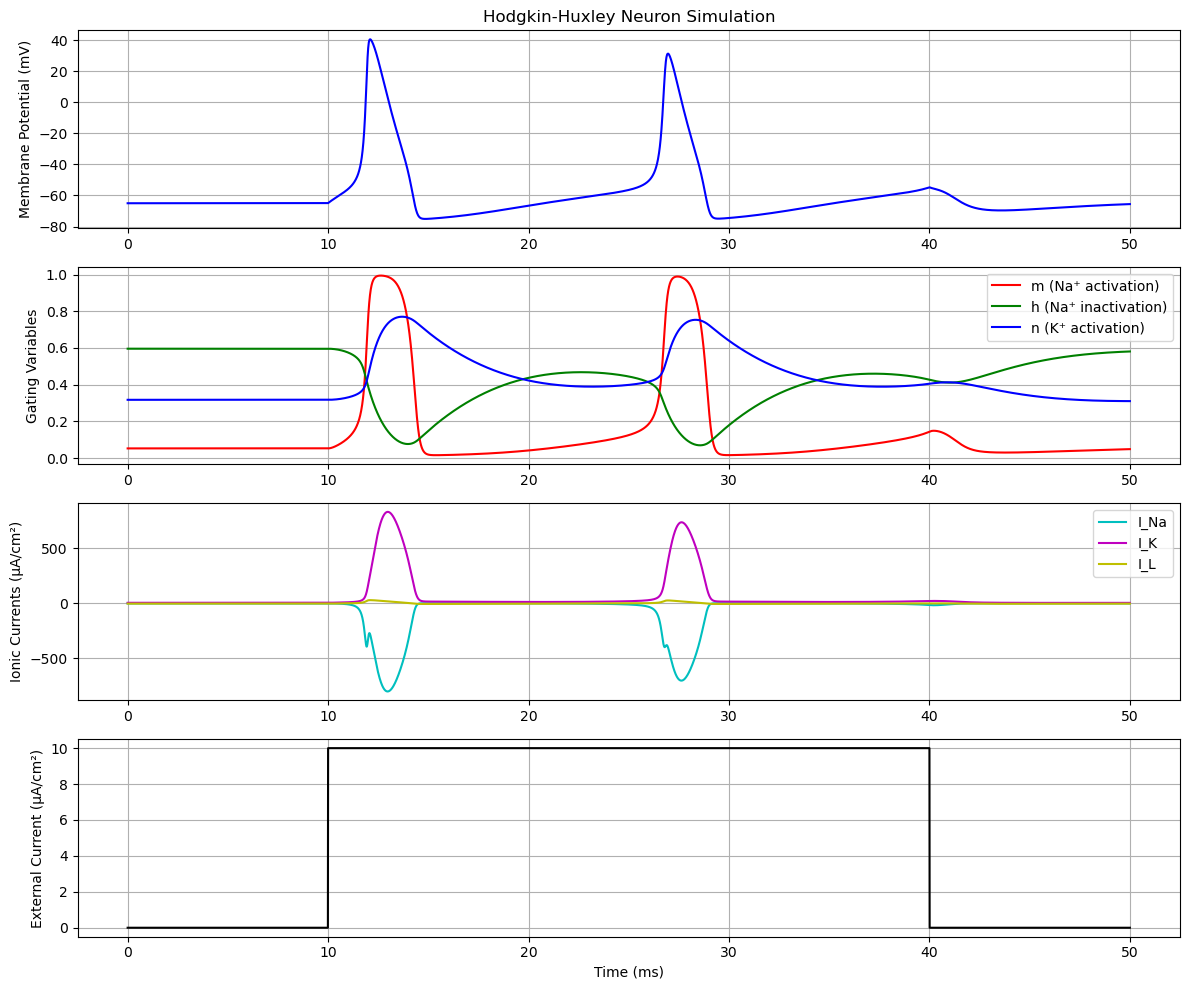

In [26]:
# Plotting results!

plot_results(t, V, m, h, n, I_ext)

In [27]:
# Applying a stronger current for a shorter duration

I_ext = define_external_current(t, amplitude=20.0, start_time=20.0, end_time=30.0)

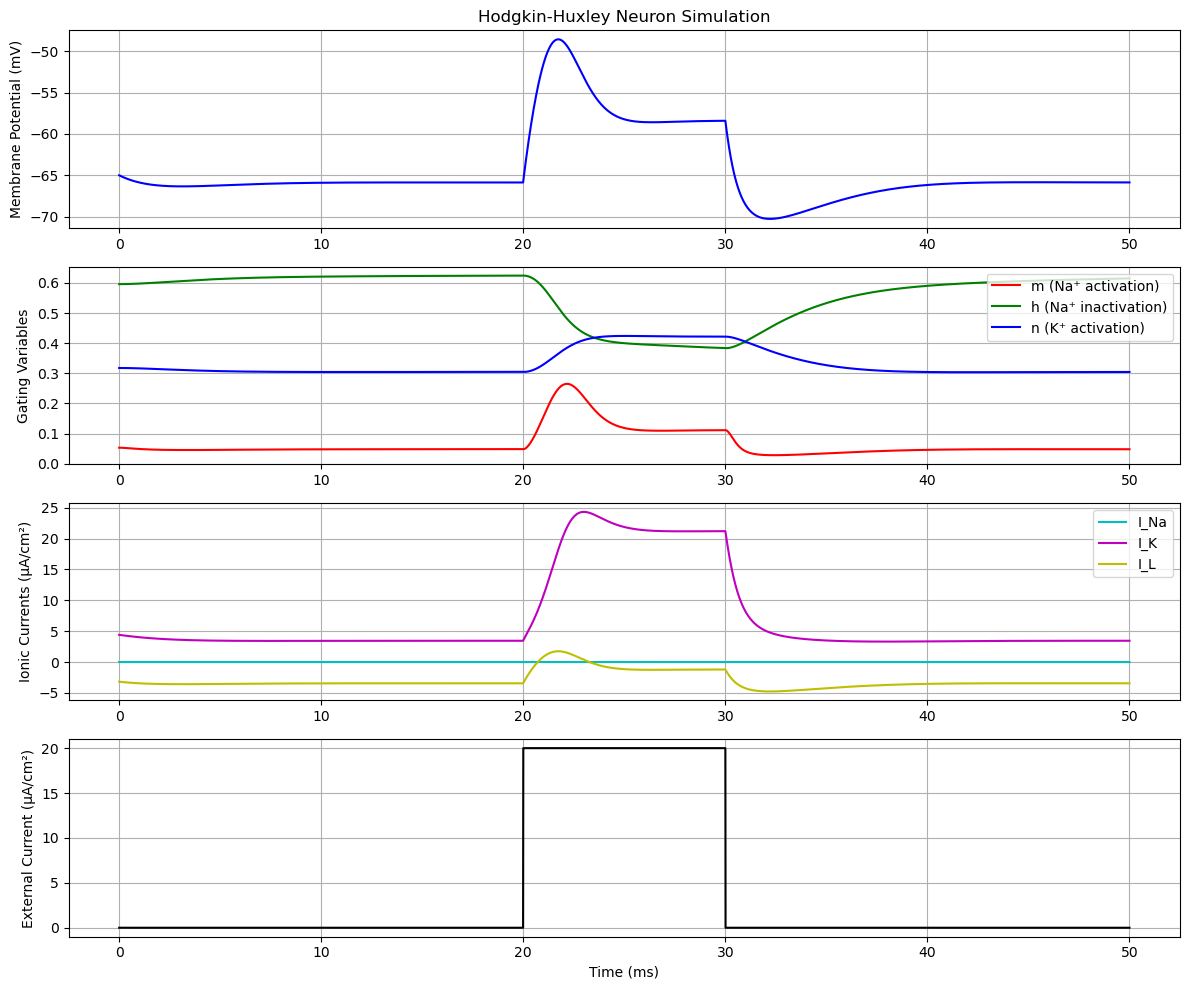

In [28]:
g_Na = 0.0

# Running the simulation again with modified parameters
V, m, h, n = hodgkin_huxley_simulation(
    V, m, h, n, t, I_ext, C_m, g_Na, g_K, g_L, E_Na, E_K, E_L
)

# Plotting the results!
plot_results(t, V, m, h, n, I_ext)

### Interactive Simulation Controls
This section allows users to dynamically adjust the simulation parameters and observe how the neuron's behavior changes in real-time. The following parameters can be customized:

- **Current Amplitude**: Controls the strength of the external stimulus applied to the neuron.
- **Start Time** and **End Time**: Set the time window for the external stimulus.
- **Na⁺ Channel**: Toggle to enable or disable the sodium ion channel.
- **K⁺ Channel**: Toggle to enable or disable the potassium ion channel.

Adjust these sliders and toggles to explore how external stimuli and channel states influence the generation of action potentials in the neuron.

In [29]:
# Create widgets for parameter control
current_amplitude = widgets.FloatSlider(
    value=10.0,
    min=0.0,
    max=50.0,
    step=1.0,
    description='Current (μA/cm²):',
    continuous_update=False
)

stimulus_start = widgets.FloatSlider(
    value=10.0,
    min=0.0,
    max=40.0,
    step=1.0,
    description='Start Time (ms):',
    continuous_update=False
)

stimulus_end = widgets.FloatSlider(
    value=40.0,
    min=10.0,
    max=50.0,
    step=1.0,
    description='End Time (ms):',
    continuous_update=False
)

sodium_toggle = widgets.Checkbox(
    value=True,
    description='Enable Na⁺ Channel',
    disabled=False
)

potassium_toggle = widgets.Checkbox(
    value=True,
    description='Enable K⁺ Channel',
    disabled=False
)

# Layout the widgets
widgets_box = widgets.VBox([
    widgets.HBox([current_amplitude]),
    widgets.HBox([stimulus_start, stimulus_end]),
    widgets.HBox([sodium_toggle, potassium_toggle])
])

In [30]:
def run_interactive_simulation(amplitude, start_time, end_time, na_enabled, k_enabled):
    # Reset parameters
    C_m, g_Na, g_K, g_L, E_Na, E_K, E_L = initialize_parameters()
    
    # Modify conductances based on channel toggles
    g_Na = g_Na if na_enabled else 0.0
    g_K = g_K if k_enabled else 0.0
    
    # Initialize simulation
    t, num_steps = initialize_simulation()
    V, m, h, n = initialize_state_variables(num_steps)
    
    # Define external current with new parameters
    I_ext = define_external_current(t, amplitude=amplitude, 
                                  start_time=start_time, 
                                  end_time=end_time)
    
    # Run simulation
    V, m, h, n = hodgkin_huxley_simulation(
        V, m, h, n, t, I_ext, C_m, g_Na, g_K, g_L, E_Na, E_K, E_L
    )
    
    # Plot results
    plot_results(t, V, m, h, n, I_ext)

# Create the interactive output
interactive_output = widgets.interactive_output(
    run_interactive_simulation,
    {
        'amplitude': current_amplitude,
        'start_time': stimulus_start,
        'end_time': stimulus_end,
        'na_enabled': sodium_toggle,
        'k_enabled': potassium_toggle
    }
)

In [32]:
# Display widgets with colored text
display(widgets.VBox([
    widgets.HTML('''
        <h3 style="color: #2471A3;">Simulation Controls</h3>
        <p style="color: #FFFFFF;">Adjust the parameters below to see how they affect the neuron's behavior:</p>
        <ul style="color: #FFFFFF;">
            <li>Current Amplitude: Controls the strength of stimulus</li>
            <li>Start/End Time: Sets stimulus timing</li>
            <li>Na+ Channel: Controls sodium current (depolarization)</li>
            <li>K+ Channel: Controls potassium current (repolarization)</li>
        </ul>
    '''),
    widgets_box,
    interactive_output
]))